In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve

from librosa.core import stft
from librosa.core import istft
from librosa import amplitude_to_db, db_to_amplitude
from librosa.display import specshow
from librosa.output import write_wav

from scipy.signal import butter, lfilter, csd
from scipy.linalg import svd, pinv, inv

from utils import apply_reverb, read_wav
import corpus
import mir_eval

import pyroomacoustics as pra

/home/tinus/Workspace/corpus/TIMIT/TRAIN/DR7/MPFU0/SX358.WAV
/home/tinus/Workspace/corpus/TIMIT/TRAIN/DR7/MPFU0/SX268.WAV


(-1, 9)

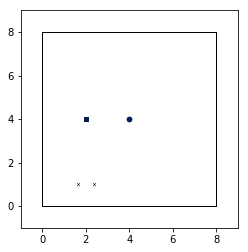

In [2]:
corners = np.array([[0,0], [0,8], [8,8], [8,0]]).T  # [x,y]
room = pra.Room.from_corners(corners)

s1, s2 = map(read_wav, corpus.experiment_files_timit_train())

if len(s1) > len(s2):
    pad_length = len(s1) - len(s2)
    s2 = np.pad(s2, (0,pad_length), 'reflect')
else:
    pad_length = len(s2) - len(s1)
    s1 = np.pad(s1, (0,pad_length), 'reflect')

room.add_source([4.,4.], signal=s1)
room.add_source([2.,4.], signal=s2)

R = pra.linear_2D_array(center=[2.,1.], M=2, phi=0, d=0.75)
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

fig, ax = room.plot()
ax.set_xlim([-1, 9])
ax.set_ylim([-1, 9])

3D case

/home/tinus/Workspace/corpus/TIMIT/TRAIN/DR8/MMPM0/SA1.WAV
/home/tinus/Workspace/corpus/TIMIT/TRAIN/DR8/MMPM0/SX161.WAV


(0, 6)

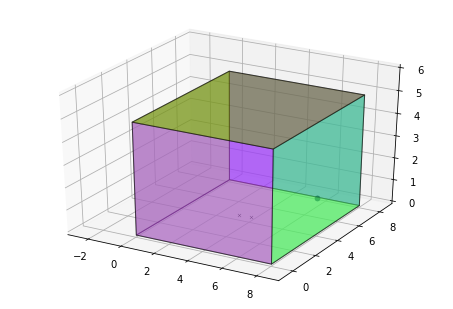

In [15]:
corners = np.array([[0,0], [0,8], [8,8], [8,0]]).T  # [x,y]
room = pra.Room.from_corners(corners)
room.extrude(5.)

s1, s2 = map(read_wav, corpus.experiment_files_timit_train())

if len(s1) > len(s2):
    pad_length = len(s1) - len(s2)
    s2 = np.pad(s2, (0,pad_length), 'reflect')
else:
    pad_length = len(s2) - len(s1)
    s1 = np.pad(s1, (0,pad_length), 'reflect')

room.add_source([8.,4.,1.6], signal=s1)
# room.add_source([2.,4.,1.6], signal=s2)
#[[X],[Y],[Z]]
R = np.asarray([[4.75,5.5],[2.,2.],[1.,1]])
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))
    
fig, ax = room.plot()
ax.set_xlim([-3, 9])
ax.set_ylim([-1, 9])
ax.set_zlim([0, 6])

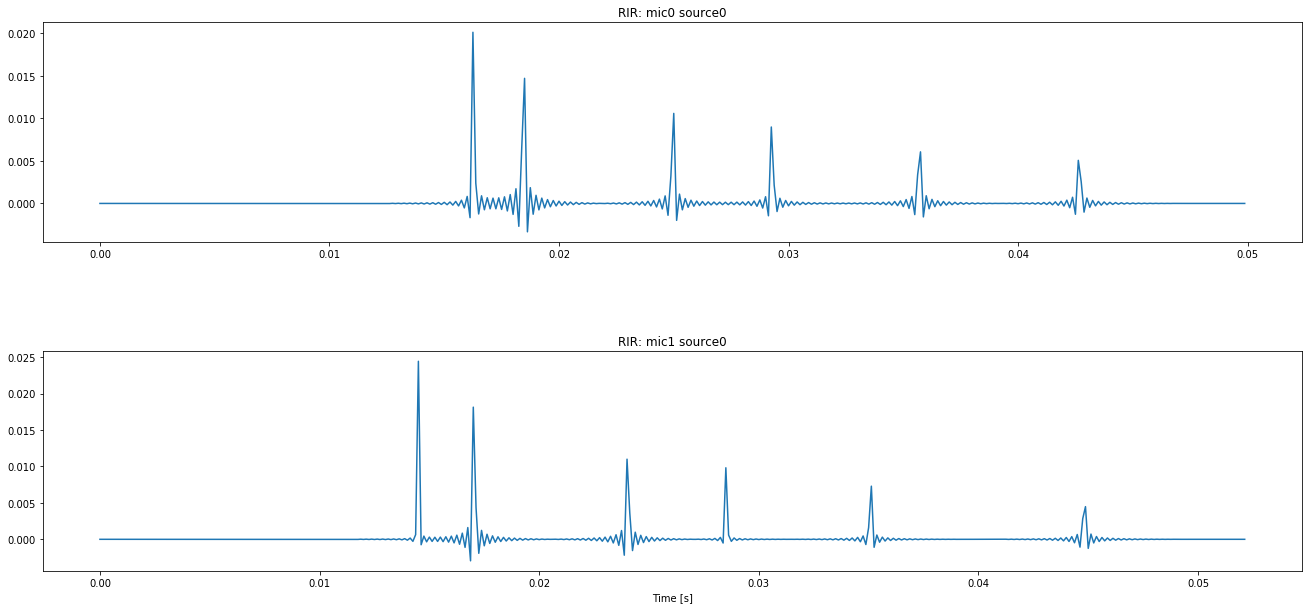

In [16]:
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(20, 10)

In [17]:
room.simulate()
print(room.mic_array.signals.shape)

(2, 66568)


In [73]:
nfft=2048
win = 1024
hop = int(nfft/8)
Y1_o = stft(room.mic_array.signals[0,:len(s1)], n_fft=nfft, hop_length=hop, win_length=win, window="barthann")
Y2_o = stft(room.mic_array.signals[1,:len(s1)], n_fft=nfft, hop_length=hop, win_length=win, window="barthann")
X1_o = stft(s1, n_fft=nfft, hop_length=hop, win_length=win, window="barthann")

Gxx = X1_o * np.conj(X1_o)
Gxy = X1_o * np.conj(Y1_o)
Gyx = Y1_o * np.conj(X1_o)
Gyy = Y1_o * np.conj(Y1_o)

temp1 = np.asarray([[Gxx, Gxy],[Gyx, Gyy]]).reshape(F*2,T*2)

Gxxx = (X1_o * X1_o * np.conj(X1_o))/Gxx
Gxyx = (X1_o * Y1_o * np.conj(X1_o))/Gxy
Gyxy = (Y1_o * X1_o * np.conj(Y1_o))/Gyx
Gyyy = (Y1_o * Y1_o * np.conj(Y1_o))/Gyy

temp2 = np.asarray([[Gxx, Gxxx, Gxy, Gxyx],[Gyx, Gyxy, Gyy, Gyyy]]).reshape(F*2,T*4)

Gxxxx = (X1_o * X1_o * X1_o * np.conj(X1_o))/Gxx
Gxyxy = (X1_o * Y1_o * X1_o * np.conj(Y1_o))/Gxy
Gyxyx = (Y1_o * X1_o * Y1_o * np.conj(X1_o))/Gyx
Gyyyy = (Y1_o * Y1_o * Y1_o * np.conj(Y1_o))/Gyy

temp3 = np.asarray([[Gxx, Gxxxx, Gxy, Gxyxy],[Gyx, Gyxyx, Gyy, Gyyyy]]).reshape(F*2,T*4)
temp4 = np.asarray([[Gxx, Gxxx, Gxxxx, Gxy, Gxyx, Gxyxy],[Gyx, Gyxy, Gyxyx, Gyy, Gyyy, Gyyyy]]).reshape(F*3,T*4)

# version 2 to see which works better
Gxxx = (X1_o/Gxx * X1_o/Gxx * np.conj(X1_o/Gxx))
Gxyx = (X1_o/Gxy * Y1_o/Gxy * np.conj(X1_o/Gxy))
Gyxy = (Y1_o/Gyx * X1_o/Gyx * np.conj(Y1_o/Gyx))
Gyyy = (Y1_o/Gyy * Y1_o/Gyy * np.conj(Y1_o/Gyy))
temp5 = np.asarray([[Gxx, Gxxx, Gxy, Gxyx],[Gyx, Gyxy, Gyy, Gyyy]]).reshape(F*2,T*4)

Gxxxx = (X1_o/Gxx * X1_o/Gxx * X1_o/Gxx * np.conj(X1_o/Gxx))
Gxyxy = (X1_o/Gxy * Y1_o/Gxy * X1_o/Gxy * np.conj(Y1_o/Gxy))
Gyxyx = (Y1_o/Gyx * X1_o/Gyx * Y1_o/Gyx * np.conj(X1_o/Gyx))
Gyyyy = (Y1_o/Gyy * Y1_o/Gyy * Y1_o/Gyy * np.conj(Y1_o/Gyy))

temp6 = np.asarray([[Gxx, Gxxxx, Gxy, Gxyxy],[Gyx, Gyxyx, Gyy, Gyyyy]]).reshape(F*2,T*4)
temp7 = np.asarray([[Gxx, Gxxx, Gxxxx, Gxy, Gxyx, Gxyxy],[Gyx, Gyxy, Gyxyx, Gyy, Gyyy, Gyyyy]]).reshape(F*3,T*4)


# Gxx = Y1_o * np.conj(Y1_o)
# Gxy = Y1_o * np.conj(Y2_o)
# Gyx = Y2_o * np.conj(Y1_o)
# Gyy = Y2_o * np.conj(Y2_o)

# temp1 = np.asarray([[Gxx, Gxy],[Gyx, Gyy]]).reshape(F*2,T*2)

# Gxxx = (Y1_o * Y1_o * np.conj(Y1_o))/Gxx
# Gxyx = (Y1_o * Y2_o * np.conj(Y1_o))/Gxy
# Gyxy = (Y2_o * Y1_o * np.conj(Y2_o))/Gyx
# Gyyy = (Y2_o * Y2_o * np.conj(Y2_o))/Gyy

# temp2 = np.asarray([[Gxx, Gxxx, Gxy, Gxyx],[Gyx, Gyxy, Gyy, Gyyy]]).reshape(F*2,T*4)

# Gxxxx = (Y1_o * Y1_o * Y1_o * np.conj(Y1_o))/Gxx
# Gxyxy = (Y1_o * Y2_o * Y1_o * np.conj(Y2_o))/Gxy
# Gyxyx = (Y2_o * Y1_o * Y2_o * np.conj(Y1_o))/Gyx
# Gyyyy = (Y2_o * Y2_o * Y2_o * np.conj(Y2_o))/Gyy

# temp3 = np.asarray([[Gxx, Gxxxx, Gxy, Gxyxy],[Gyx, Gyxyx, Gyy, Gyyyy]]).reshape(F*2,T*4)
# temp4 = np.asarray([[Gxx, Gxxx, Gxxxx, Gxy, Gxyx, Gxyxy],[Gyx, Gyxy, Gyxyx, Gyy, Gyyy, Gyyyy]]).reshape(F*3,T*4)

# # version 2 to see which works better
# Gxxx = (Y1_o/Gxx * Y1_o/Gxx * np.conj(Y1_o/Gxx))
# Gxyx = (Y1_o/Gxy * Y2_o/Gxy * np.conj(Y1_o/Gxy))
# Gyxy = (Y2_o/Gyx * Y1_o/Gyx * np.conj(Y2_o/Gyx))
# Gyyy = (Y2_o/Gyy * Y2_o/Gyy * np.conj(Y2_o/Gyy))
# temp5 = np.asarray([[Gxx, Gxxx, Gxy, Gxyx],[Gyx, Gyxy, Gyy, Gyyy]]).reshape(F*2,T*4)

# Gxxxx = (Y1_o/Gxx * Y1_o/Gxx * Y1_o/Gxx * np.conj(Y1_o/Gxx))
# Gxyxy = (Y1_o/Gxy * Y2_o/Gxy * Y1_o/Gxy * np.conj(Y2_o/Gxy))
# Gyxyx = (Y2_o/Gyx * Y1_o/Gyx * Y2_o/Gyx * np.conj(Y1_o/Gyx))
# Gyyyy = (Y2_o/Gyy * Y2_o/Gyy * Y2_o/Gyy * np.conj(Y2_o/Gyy))

# temp6 = np.asarray([[Gxx, Gxxxx, Gxy, Gxyxy],[Gyx, Gyxyx, Gyy, Gyyyy]]).reshape(F*2,T*4)
# temp7 = np.asarray([[Gxx, Gxxx, Gxxxx, Gxy, Gxyx, Gxyxy],[Gyx, Gyxy, Gyxyx, Gyy, Gyyy, Gyyyy]]).reshape(F*3,T*4)

F,T = Gxx.shape
print(Gxx.shape)
print(Gxy.shape)
print(Gyx.shape)
print(Gyy.shape)

(1025, 259)
(1025, 259)
(1025, 259)
(1025, 259)


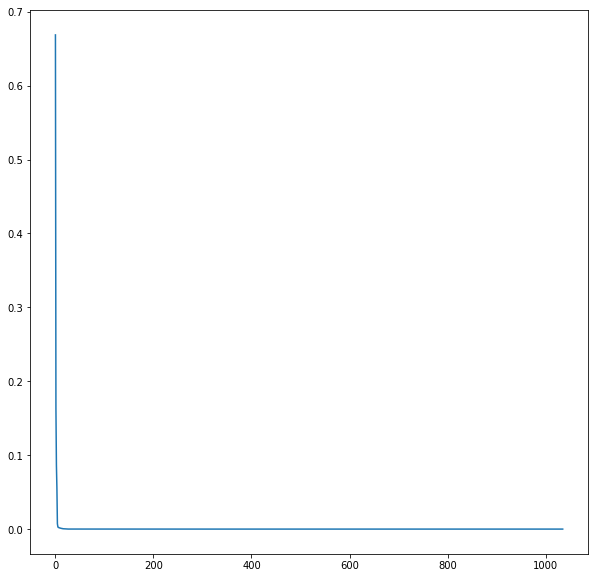

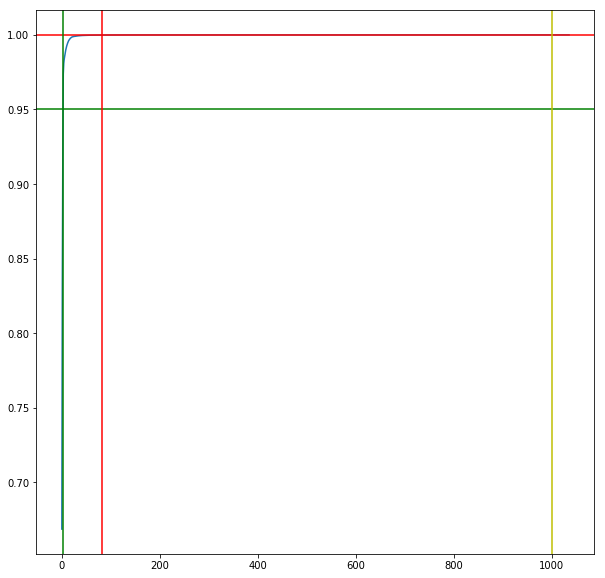

In [74]:
from scipy.linalg import svd, pinv
temp = temp5
temp_F, temp_T = temp.shape
U, s, V = svd(temp)
plt.figure(figsize=(10,10))
plt.plot(s/sum(s))
tmpsum = 0
summed = []
for i in range(len(s)):
    tmpsum += s[i]/sum(s)
    summed.append(tmpsum)
summed = np.asarray(summed)
n_95 = np.where(summed>0.95)[0][0]
n_9999 = np.where(summed>0.9999)[0][0]
n_999999 = np.where(summed>0.999999)[0][0]
plt.figure(figsize=(10,10))
plt.plot(summed)
plt.axhline(y=0.95, color='g')
plt.axhline(y=0.9999, color='r')
plt.axvline(x=n_95, color='g')
plt.axvline(x=n_9999, color='r')
plt.axvline(x=n_999999, color='y')

In [75]:
sx = 0.1
sy = 2

smallU95p = sx *U[:,:n_95].reshape(temp_F,-1)
smallU9999p = sx * U[:,:n_9999].reshape(temp_F,-1)
smallU999999p = sx * U[:,:n_999999].reshape(temp_F,-1)
smallV95p = sy * V[:n_95,:].reshape(-1, temp_T)
smallV9999p = sy * V[:n_9999,:].reshape(-1, temp_T)
smallV999999p = sy * V[:n_999999,:].reshape(-1, temp_T)

# smallU95p = U[:,:n_95].reshape(F*2,-1)
# smallU9999p = U[:,:n_9999].reshape(F*2,-1)
# smallU999999p = U[:,:n_999999].reshape(F*2,-1)
# smallV95p = V[:n_95,:].reshape(-1, T*2)
# smallV9999p = V[:n_9999,:].reshape(-1, T*2)
# smallV999999p = V[:n_999999,:].reshape(-1, T*2)

Hs95p = np.matmul(smallU95p[:F,:],pinv(smallV95p[:,:T]).T)
Hs9999p = np.matmul(smallU9999p[:F,:],pinv(smallV9999p[:,:T]).T)
Hs999999p = np.matmul(smallU999999p[:F,:],pinv(smallV999999p[:,:T]).T)


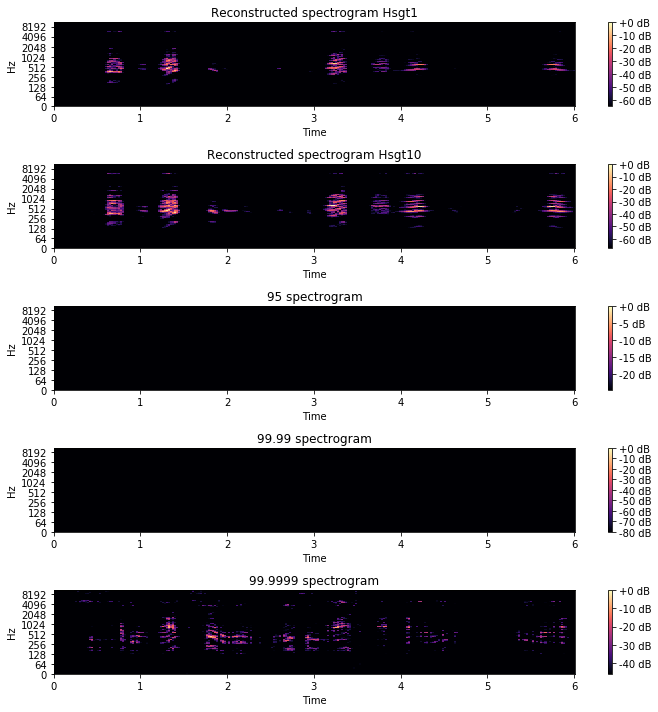

In [76]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(511)
specshow(amplitude_to_db(np.multiply(Hsgt1,Y1_o), ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram Hsgt1')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
ax1 = plt.subplot(512)
specshow(amplitude_to_db(np.multiply(Hsgt10,Y1_o), ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram Hsgt10')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.subplot(513, sharex=ax1)
specshow(amplitude_to_db(np.multiply(Hs95p,Y1_o), ref=np.max), y_axis='log', x_axis='time')
plt.title('95 spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.subplot(514, sharex=ax1)
specshow(amplitude_to_db(np.multiply(Hs9999p,Y1_o), ref=np.max), y_axis='log', x_axis='time')
plt.title('99.99 spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.subplot(515, sharex=ax1)
specshow(amplitude_to_db(np.multiply(Hs999999p,Y1_o), ref=np.max), y_axis='log', x_axis='time')
plt.title('99.9999 spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

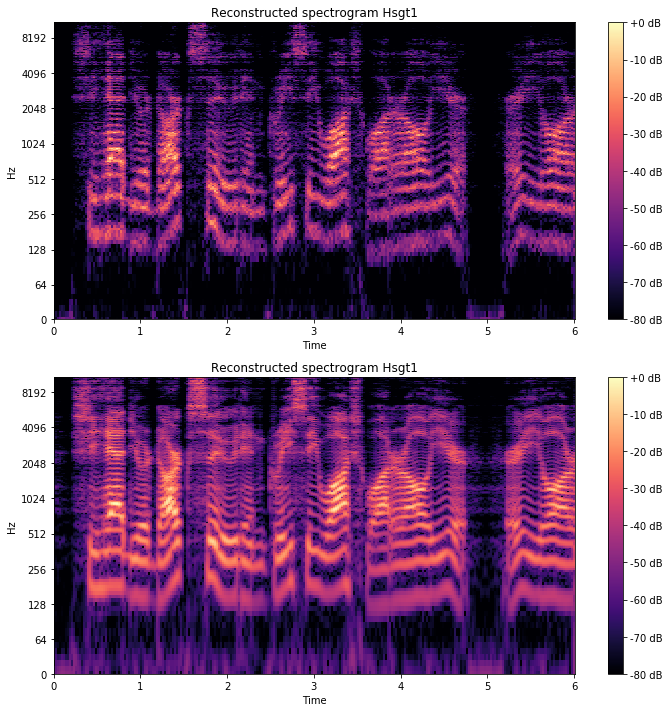

In [32]:
filter_result = np.multiply(pinv(Hs999999p).T,Y1_o)
plt.figure(figsize=(10,10))
ax1 = plt.subplot(211)
specshow(amplitude_to_db(filter_result, ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram Hsgt1')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
ax1 = plt.subplot(212)
specshow(amplitude_to_db(Y1_o, ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram Hsgt1')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

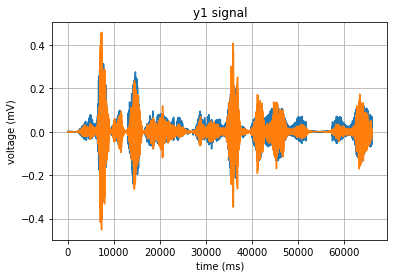

In [22]:
filter_result = np.multiply(pinv(Hs999999p).T,Y1_o)
recon_y1_Hs = istft(filter_result, hop_length=hop, win_length=win, window="barthann")*1000
fig, ax = plt.subplots()
ax.plot(s1)
ax.plot(recon_y1_Hs)


ax.set(xlabel='time (ms)', ylabel='voltage (mV)',
       title='y1 signal')
ax.grid()
write_wav('removed_reverb_Hsgt1.wav', recon_y1_Hs, 16000)

In [91]:
def amp_correction(ref_signal, new_signal):
    db_ref = amplitude_to_db(ref_signal)
    db_new = amplitude_to_db(new_signal)
    print(np.mean((db_ref - db_new)))
    db_new += np.mean((db_ref - db_new))+20
    return db_to_amplitude(db_new)

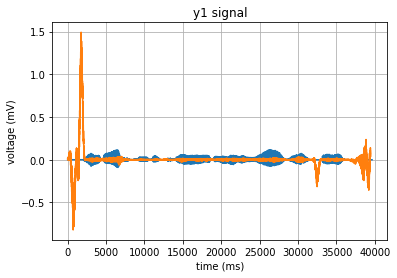

In [11]:
recon_Y1_Hsgt1 = np.multiply(Hsgt1,Y1_o)
recon_Y1_Hsgt10 = np.multiply(Hsgt10,Y1_o)
recon_Y1_Hs95p = np.multiply(Hs95p,Y1_o)
recon_Y1_Hs9999p = np.multiply(Hs9999p,Y1_o)
recon_Y1_Hs999999p = np.multiply(Hs999999p,Y1_o)

recon_y1_Hs95p = istft(recon_Y1_Hs95p, hop_length=hop, win_length=win)
recon_y1_Hs9999p = istft(recon_Y1_Hs9999p, hop_length=hop, win_length=win)
recon_y1_Hs999999p = istft(recon_Y1_Hs999999p, hop_length=hop, win_length=win)
recon_y1_Hsgt1 = istft(recon_Y1_Hsgt1, hop_length=hop, win_length=win)
recon_y1_Hsgt10 = istft(recon_Y1_Hsgt10, hop_length=hop, win_length=win)

fig, ax = plt.subplots()
ax.plot(s1)
ax.plot(recon_y1_Hs999999p*1000)


ax.set(xlabel='time (ms)', ylabel='voltage (mV)',
       title='y1 signal')
ax.grid()



write_wav('removed_reverb_Hsgt1.wav', recon_y1_Hsgt1, 16000)
write_wav('removed_reverb_Hsgt10.wav', recon_y1_Hsgt10, 16000)

In [12]:
nfft=2048
win = 1024
hop = int(nfft/8)
Y1_o = stft(room.mic_array.signals[0,:len(s1)], n_fft=nfft, hop_length=hop, win_length=win)
Y2_o = stft(room.mic_array.signals[1,:len(s1)], n_fft=nfft, hop_length=hop, win_length=win)
X1_o = stft(s1, n_fft=nfft, hop_length=hop, win_length=win)
X1 = np.power(np.abs(X1_o),2)
Y1 = np.power(np.abs(Y1_o),2)
Y2 = np.power(np.abs(Y2_o),2)
Gxx = X1 * np.conj(X1)
Gxy = X1 * np.conj(Y1)
Gyx = Y1 * np.conj(X1)
Gyy = Y1 * np.conj(Y1)
F,T = Gxx.shape
print(Gxx.shape)
print(Gxy.shape)
print(Gyx.shape)
print(Gyy.shape)

(1025, 155)
(1025, 155)
(1025, 155)
(1025, 155)


(2050, 310)


ValueError: shapes (1025,341) and (310,155) not aligned: 341 (dim 1) != 310 (dim 0)

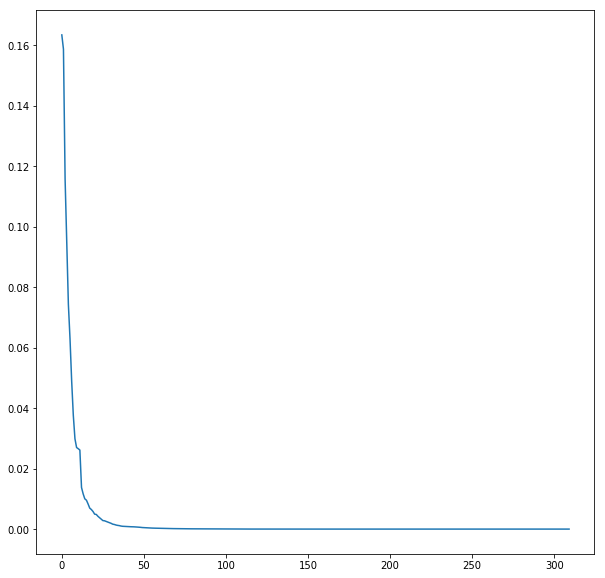

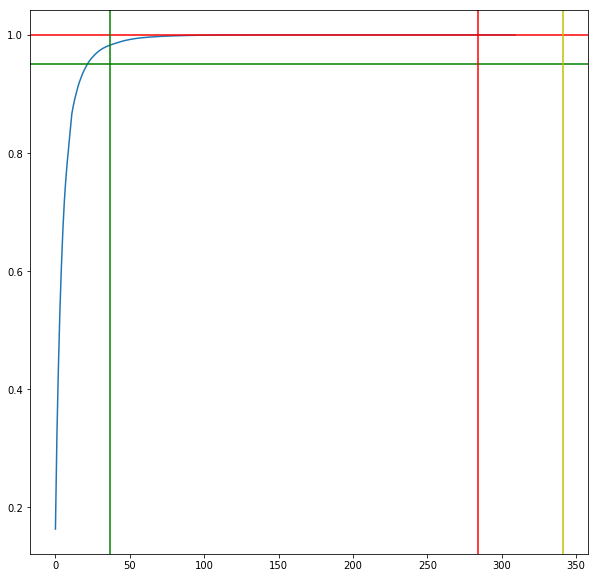

In [13]:
from scipy.linalg import svd, pinv
temp = np.asarray([[Gxx, Gxy],[Gyx, Gyy]]).reshape(F*2,T*2)
print(temp.shape)
U, s, V = svd(temp)
plt.figure(figsize=(10,10))
plt.plot(s/sum(s))
tmpsum = 0
summed = []
for i in range(len(s)):
    tmpsum += s[i]/sum(s)
    summed.append(tmpsum)
summed = np.asarray(summed)
plt.figure(figsize=(10,10))
plt.plot(summed)
plt.axhline(y=0.95, color='g')
plt.axhline(y=0.9999, color='r')
plt.axvline(x=37, color='g')
plt.axvline(x=284, color='r')
plt.axvline(x=341, color='y')

smallUgt1 = U[:,np.where(s>1)].reshape(F*2,-1)
smallUgt10 = U[:,np.where(s>0.5)].reshape(F*2,-1)
smallVgt1 = V[np.where(s>1),:].reshape(-1, T*2)
smallVgt10 = V[np.where(s>0.5),:].reshape(-1, T*2)

Hsgt1 = np.matmul(smallUgt1[:F,:],pinv(smallVgt1[:,T:]).T)
Hsgt10 = np.matmul(smallUgt10[:F,:],pinv(smallVgt10[:,T:]).T)

smallU95p = U[:,:37].reshape(F*2,-1)
smallU9999p = U[:,:284].reshape(F*2,-1)
smallU999999p = U[:,:341].reshape(F*2,-1)
smallV95p = V[:37,:].reshape(-1, T*2)
smallV9999p = V[:284,:].reshape(-1, T*2)
smallV999999p = V[:341,:].reshape(-1, T*2)

Hs95p = np.matmul(smallU95p[:F,:],pinv(smallV95p[:,T:]).T)
Hs9999p = np.matmul(smallU9999p[:F,:],pinv(smallV9999p[:,T:]).T)
Hs999999p = np.matmul(smallU999999p[:F,:],pinv(smallV999999p[:,T:]).T)

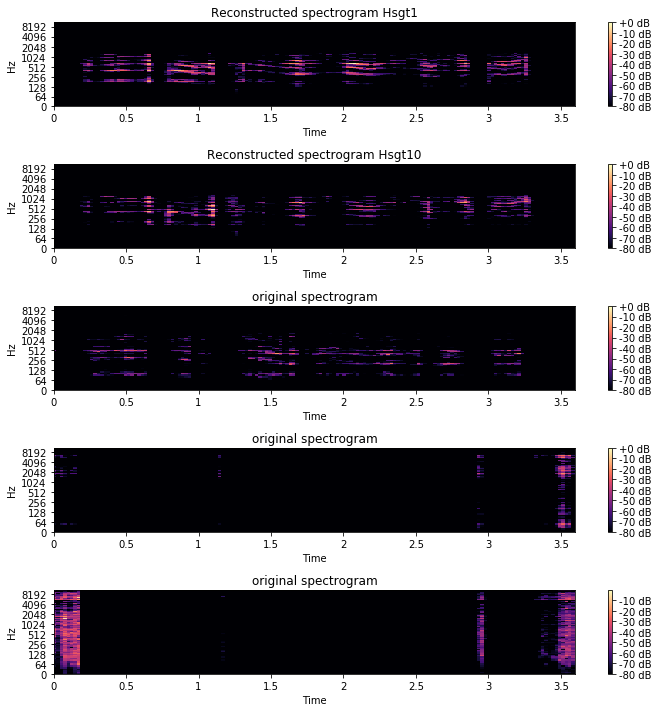

In [14]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(511)
specshow(amplitude_to_db(np.multiply(Hsgt1,Y1), ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram Hsgt1')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
ax1 = plt.subplot(512)
specshow(amplitude_to_db(np.multiply(Hsgt10,Y1), ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram Hsgt10')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.subplot(513, sharex=ax1)
specshow(amplitude_to_db(np.multiply((Hs95p/Y1),Y1_o), ref=np.max), y_axis='log', x_axis='time')
plt.title('original spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.subplot(514, sharex=ax1)
specshow(amplitude_to_db(np.multiply((Hs9999p/Y1),Y1_o), ref=np.max), y_axis='log', x_axis='time')
plt.title('original spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.subplot(515, sharex=ax1)
specshow(amplitude_to_db(np.multiply((Hs999999p/Y1),Y1_o), ref=np.max), y_axis='log', x_axis='time')
plt.title('original spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()